In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import os

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import importlib
import plot, loaders
plot = importlib.reload(plot)
loaders = importlib.reload(loaders)

In [3]:
PGS_DIR = os.path.join("data", "pgs")
SAVE_FIG_DIR = "figureS2-2"

# Multi-trait Gain as function of # siblings

## Longevity Model

In [4]:
longevity_data = loaders.load_longevity_data(pgs_col=os.path.join(PGS_DIR, "longevity_height"), convert_to_cm=True)
longevity_data.rename(columns={"PGS": "Height_PGS"}, inplace=True)
longevity_data.head(2)

const  Gender  Age  Height_PGS  Height
FID IID                                        
2   427    1.0       0   61    0.000028  157.48
    448    1.0       1   62    0.000028  177.80

In [5]:
longevity_bmi_data = loaders.load_longevity_bmi_data(pgs_col=os.path.join(PGS_DIR, "longevity_bmi"), negate_bmi=False)
# longevity_bmi_data["BMI"] = 1 / longevity_bmi_data["BMI"]
longevity_bmi_data.rename(columns={"PGS": "BMI_PGS"}, inplace=True)
longevity_bmi_data = longevity_bmi_data[["BMI_PGS", "BMI"]]
longevity_data = longevity_data.merge(longevity_bmi_data, left_index=True, right_index=True)
longevity_data.head(3)

const  Gender  Age  Height_PGS  Height   BMI_PGS        BMI
FID IID                                                             
2   427    1.0       0   61    0.000028  157.48 -0.000056  27.454936
    448    1.0       1   62    0.000028  177.80 -0.000050  30.272873
11  615    1.0       0   64    0.000042  157.48 -0.000053  24.563013

#### Logenvity Height Model

In [6]:
height_model_covar = sm.OLS.from_formula("Height ~ Gender + Age", longevity_data).fit()
print("Covaraite model:", height_model_covar.rsquared)
longevity_data["Height_resid"] = height_model_covar.resid
height_model_pgs_res = sm.OLS.from_formula("Height_resid ~ Height_PGS", longevity_data).fit()
# print(height_model_pgs_res.summary())
print("PGS model:", height_model_pgs_res.rsquared)

Covaraite model: 0.6058148508038617
PGS model: 0.23920540192728923


#### Longevity BMI Model

In [7]:
# bmi_model_covar = sm.OLS.from_formula("BMI ~ Gender + Age + Age:Gender", longevity_data).fit()
bmi_model_covar = sm.OLS.from_formula("BMI ~ Gender + Age", longevity_data).fit()
print("Covaraite model:", bmi_model_covar.rsquared)
longevity_data["BMI_resid"] = bmi_model_covar.resid
bmi_model_pgs_res = sm.OLS.from_formula("BMI_resid ~ BMI_PGS", longevity_data).fit()
# print(height_model_pgs_res.summary())
print("PGS model:", bmi_model_pgs_res.rsquared)

Covaraite model: 0.024434791823445323
PGS model: 0.03101624361721622


## Prediction

In [8]:
longevity_so_10_height_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_10_height"), "Height_PGS")
longevity_so_10_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_10_height_pgs))
# longevity_so_10_height_pred.head(3)

In [9]:
longevity_so_10_bmi_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_10_bmi"), "BMI_PGS")
longevity_so_10_bmi_pred = bmi_model_pgs_res.predict(sm.add_constant(longevity_so_10_bmi_pgs))
# longevity_so_10_bmi_pred.head(3)

In [10]:
longevity_so_10_pred = pd.DataFrame({"Height": longevity_so_10_height_pred,
                                     "BMI": longevity_so_10_bmi_pred})
longevity_so_10_pred.head(3)

BMI    Height
FID       IID                     
1130_2269 SO00 -0.176035 -0.519450
          SO01 -0.014971 -1.060720
          SO02  0.452341 -0.161965

### Trait weight

In [11]:
# trait_weights = 1 / longevity_so_50_pred.std()  # redundant due to siblings & synthetic
# trait_weights = 1 / pd.Series({"Height": height_model_pgs_res.model.endog.std(),
#                                "BMI": bmi_model_pgs_res.model.endog.std()})  # prefers better predicted traits
trait_weights = 1 / pd.Series({"Height": height_model_pgs_res.fittedvalues.std(),
                               "BMI": bmi_model_pgs_res.fittedvalues.std()})  # treats traits equally regardless of pred power

# # BMI trait lower is better so make it a negative (so next when selecting with height it would be consistent greater is better)
trait_weights["BMI"] *= -1

trait_weights

BMI      -1.285990
Height    0.334509
dtype: float64

In [12]:
longevity_so_10_pred = longevity_so_10_pred.join(longevity_so_10_pred * trait_weights, rsuffix="_std")
longevity_so_10_pred.head(3)

BMI    Height   BMI_std  Height_std
FID       IID                                           
1130_2269 SO00 -0.176035 -0.519450  0.226379   -0.173761
          SO01 -0.014971 -1.060720  0.019253   -0.354820
          SO02  0.452341 -0.161965 -0.581706   -0.054179

In [13]:
longevity_so_10_pred.std()

BMI           0.766680
Height        2.946709
BMI_std       0.985943
Height_std    0.985700
dtype: float64

**trait correlation**

In [182]:
longevity_corr = height_model_pgs_res.fittedvalues.corr(bmi_model_pgs_res.fittedvalues)

## Compare to theoretical model

#### Calculate gain

In [30]:
def calculate_gain(df, convex_weight=0.5, groupby_colname="FID", greater_is_better=True):
    res = {}
    df = df.copy()
    df["mix"] = (convex_weight*df["Height_std"]) + ((1-convex_weight)*df["BMI_std"])
    df_gb = df.groupby(groupby_colname)
#     for select_by in ["Height", "BMI", "mix"]:
    for select_by in ["Height_std", "BMI_std", "mix"]:
        if greater_is_better:
            best = df_gb[select_by].idxmax()
            gain = df.loc[best] - df_gb.mean()
        else:
            best = df_gb[select_by].idxmin()
            gain = df_gb.mean() - df.loc[best]
        gain = gain.agg(["mean", "sem", "std"]).T
        gain["ci95"] = stats.norm.ppf(0.95) * gain["sem"]
        res[select_by] = gain
    res = pd.concat(res, names=["select", "trait"])
    return res

def calculate_weighted_gains(df, convex_weights=None, groupby_colname="FID", greater_is_better=True):
    if convex_weights is None:
        convex_weights = np.linspace(0, 1, 11)
    res = {}
    for convex_weight in convex_weights:
        res[convex_weight] = calculate_gain(df, convex_weight, groupby_colname, greater_is_better)
    res = pd.concat(res, names=["conv_weight"])
    return res

In [31]:
so_wgain = calculate_weighted_gains(longevity_so_10_pred)
so_wgain.sample(6)

mean       sem       std      ci95
conv_weight select     trait                                             
1.0         mix        Height_std  1.019907  0.015410  0.343894  0.025348
0.3         Height_std BMI        -0.063084  0.022192  0.495236  0.036503
0.2         Height_std BMI_std     0.081126  0.028539  0.636868  0.046942
1.0         Height_std mix         1.019907  0.015410  0.343894  0.025348
0.4         BMI_std    BMI_std     1.038077  0.014836  0.331078  0.024403
                       Height_std  0.049479  0.028859  0.644020  0.047469

#### Extract PG scores of current parents

In [33]:
so_wgain = so_wgain.reorder_levels(["select", "trait", "conv_weight"])
so_wgain = so_wgain.rename(index=lambda x: x.split("_")[0], level="select")
so_wgain.head(5)

mean       sem       std      ci95
select trait      conv_weight                                        
BMI    BMI        0.0         -0.807220  0.011537  0.257450  0.018976
       Height     0.0          0.147917  0.086273  1.925271  0.141907
       BMI_std    0.0          1.038077  0.014836  0.331078  0.024403
       Height_std 0.0          0.049479  0.028859  0.644020  0.047469
       mix        0.0          1.038077  0.014836  0.331078  0.024403

In [183]:
# pgs_models = {"Height": height_model_pgs_res, "BMI": bmi_model_pgs_res}
# import pickle
# with open(os.path.join(SAVE_FIG_DIR, "plot_data.pkl"), "wb") as fh:
#     pickle.dump((so_gain, pgs_models, parents_correlations, trait_weights, longevity_corr), fh)
# # with open(os.path.join(SAVE_FIG_DIR, "plot_data.pkl"), "rb") as fh:
# #     z = pickle.load(fh)

In [184]:
# import pickle
# with open(os.path.join(SAVE_FIG_DIR, "plot_data.pkl"), "rb") as fh:
#     z = pickle.load(fh)
# so_gain, pgs_models, parents_correlations, trait_weights, longevity_corr = z

### Plot

In [34]:
PLOT_THICKENS = True
if PLOT_THICKENS:
    # sns.plotting_context("talk")
    CUSTOM_SNS_RC = {'xtick.labelsize': 13.5, 'ytick.labelsize': 13.5, 'legend.fontsize': 13.0, 
                                                 'axes.labelsize': 14, 'axes.titlesize': 15}
    # sns.set_context("paper", font_scale=1.4, rc=CUSTOM_SNS_RC)
    sns.set_context("talk", font_scale=1, rc=CUSTOM_SNS_RC)
else:
    sns.set_context("paper")
    plt.rcParams['xtick.major.pad']= '0'
    plt.rcParams['ytick.major.pad']= '1'
    plt.rcParams['legend.fontsize'] = '7.5'

In [396]:
def gauss_max_exp(n, approx=False, approx_scale=0.77):
    if approx:
        phi_max = np.sqrt(np.log(n)) * approx_scale
    else:
        gamma = 0.5772
        phi_max = stats.norm().ppf(1 - 1/n)
        phi_max += gamma / (n * stats.norm().pdf(phi_max))
        phi_max /= np.sqrt(2)
    return phi_max

In [410]:
def single_plot_1y(empirical_gain, trait, sm_model, trait_corr, weights,
                   negate_trait=False, approx_max=False, x_percent=True,
                   y_label=None, x_label=None, legend_loc=None, ax=None):
    ax = ax or plt.gca()
    empirical_gain = empirical_gain.reset_index("conv_weight")
    if x_percent:
        empirical_gain["conv_weight"] *= 100
#         x_label += " [%]"
    
    # Plot gain by selecting on a mix:
    gain_by_mixed = empirical_gain.xs(["mix", trait], level=["select", "trait"])
    gain_by_mixed = gain_by_mixed.sort_values("conv_weight")
    if negate_trait:
        gain_by_mixed["mean"] *= -1
    ax.plot(gain_by_mixed["conv_weight"], gain_by_mixed["mean"], 
            marker="s", markersize=8, color="C2",
            label="Empirical")
    ax.fill_between(x=gain_by_mixed["conv_weight"], 
                    y1=(gain_by_mixed["mean"] - gain_by_mixed["ci95"]), 
                    y2=(gain_by_mixed["mean"] + gain_by_mixed["ci95"]), 
                    alpha=0.2, label="95% CI", color="C2")
    
    # Plot theoretical curve:
    sigma_y_hat = sm_model.model.endog.std() * np.sqrt(sm_model.rsquared)  # == sm_model.fittedvalues.std()
    expected_family_max = gauss_max_exp(10, approx_max)  # n_sibs = 10
    lambdas = np.linspace(0, 1, 101)
    theoretical_numerator = expected_family_max * sigma_y_hat
    if weights[trait] > 0:
        theoretical_numerator *= (lambdas - trait_corr*(1-lambdas))
    else:
        theoretical_numerator *= ((lambdas-1) + trait_corr*lambdas)
    theoretical_denominator = np.sqrt(lambdas**2 + (1-lambdas)**2 - 2*trait_corr*lambdas*(1-lambdas))
    theoretical_curve = theoretical_numerator / theoretical_denominator
    if x_percent:
        lambdas *= 100
    if negate_trait:
        theoretical_curve *= -1
    lambdas = np.sort(lambdas)   # reverse x-axis for BMI, force the same order as in height. 
    # comparable with: theoretical_curve = theoretical_curve[::-1] if trait == "BMI"
    color = "C3"  # "C3"
    ax.plot(lambdas, theoretical_curve, 
            color=color, label="Theoretical")
    
    ax.yaxis.set_tick_params(pad=1.8)
    ax.yaxis.labelpad = 1.8
    ax.xaxis.set_tick_params(pad=3)
    ax.xaxis.labelpad = 3

    # Edit:
    ax.legend(loc=legend_loc)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return ax

In [414]:
def plot_figure(gain, height_model, bmi_model, trait_correlation, trait_weights,
                negate_bmi, approx_max, x_percent,
                plot_thickens, legend_loc="lower right", figsize=(12, 5)):
    legend_loc = "lower right"
    if x_percent:
        xlabel = "Selection strength towards height [%]"
    else:
        xlabel ="Weight of height ($\lambda$)"
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

    single_plot_1y(gain, "Height", height_model, trait_correlation,
                   trait_weights, approx_max=approx_max, x_percent=x_percent,
                   legend_loc=legend_loc,
                   y_label="Gain [cm]", x_label=xlabel, ax=axes[0])
    axes[0].set_title("Height")

    y_label = "Gain [kg/m$^2$]"
    if negate_bmi:
        y_label = "-" + y_label
        legend_loc = "lower left"
    single_plot_1y(gain, "BMI", bmi_model, trait_correlation,
                   trait_weights, negate_bmi, approx_max, x_percent=x_percent,
                   legend_loc=legend_loc,
                   y_label=y_label, x_label=xlabel, ax=axes[1])
    axes[1].set_title("BMI")

    suptitle = "Multi-trait Gain as Function of Selection Toward Single Trait"
    if plot_thickens:
        fig.suptitle(suptitle, fontsize=18, y=1.03)
        fig.subplots_adjust(wspace=0.25)
    else:
        fig.suptitle(suptitle, fontsize=14, y=1.00)
        fig.subplots_adjust(wspace=0.3)
    
    return fig, axes

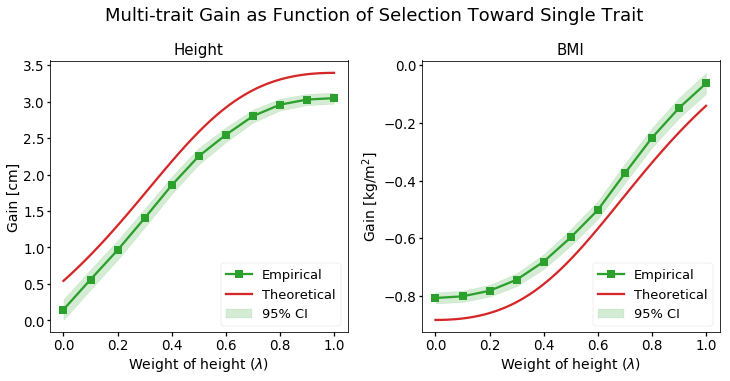

In [417]:
NEGATE_BMI = False
APPROX_MAX = False
X_PERCENT = False
fig, axes_left = plot_figure(so_wgain, height_model_pgs_res, bmi_model_pgs_res,
                             longevity_corr, trait_weights, NEGATE_BMI,
                             APPROX_MAX, X_PERCENT, PLOT_THICKENS)

In [418]:
file_name = ("multitrait-gain-by-select-strength" + 
            ("_neg-bmi" if NEGATE_BMI else "") +
            ("_x-percent" if X_PERCENT else "") +
            ("_thick" if PLOT_THICKENS else "") + 
            ("_approx" if APPROX_MAX else ""))
print(file_name)
plot.save_fig(fig, file_name, SAVE_FIG_DIR)

multitrait-gain-by-select-strength_thick


In [388]:
def plot_figure_single_box_two_axes(empirical_gain, negate_bmi=True, x_percent=True):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    empirical_gain = empirical_gain.reset_index("conv_weight")
    empirical_gain = empirical_gain.sort_values("conv_weight")
    if x_percent:
        empirical_gain["conv_weight"] *= 100
    
    height_gain = empirical_gain.xs(["mix", "Height"], level=["select", "trait"])
    ax.plot(height_gain["conv_weight"], height_gain["mean"], 
            marker="s", color="C2", markersize=8,
            label="Height")
    ax.fill_between(x=height_gain["conv_weight"], 
                    y1=(height_gain["mean"] - height_gain["ci95"]), 
                    y2=(height_gain["mean"] + height_gain["ci95"]), 
                    alpha=0.2, label=None, color="C2")
    ax.set_ylabel("Gain [cm]")
    
    
    ax2 = ax.twinx()
    y_label = "Gain [kg/m$^2$]"
    bmi_gain = empirical_gain.xs(["mix", "BMI"], level=["select", "trait"])
    if negate_bmi:
        bmi_gain["mean"] *= -1
        y_label = "-" + y_label
    ax2.plot(bmi_gain["conv_weight"], bmi_gain["mean"], 
             marker="s", linestyle="--", color="C2", markersize=8,
             label="BMI")
    ax2.fill_between(x=bmi_gain["conv_weight"], 
                     y1=(bmi_gain["mean"] - bmi_gain["ci95"]), 
                     y2=(bmi_gain["mean"] + bmi_gain["ci95"]), 
                     alpha=0.2, label=None, color="C2")
    ax2.set_ylabel(y_label)
    
    
    ax.plot([], [], marker="s", linestyle="--", color="C2", markersize=8, label="BMI")
    ax.fill_between(x=[], y1=[], y2=[], color="grey", alpha=0.2, label="95% CI")
    legend_loc = "lower center" if negate_bmi else "lower right"
    ax.legend(loc=legend_loc, handlelength=3)
    x_label = "Selection strength towards height"
    if x_percent:
        x_label += " [%]"
    ax.set_xlabel(x_label)
    
    for a in [ax, ax2]:
        a.yaxis.set_tick_params(pad=3)
        a.yaxis.labelpad = 3
        a.xaxis.set_tick_params(pad=3)
        a.xaxis.labelpad = 3
    
    return fig, ax

In [389]:
NEGATE_BMI = False
fig, ax = plot_figure_single_box_two_axes(so_wgain, negate_bmi=NEGATE_BMI);

In [390]:
file_name = ("multitrait-gain-by-select-strength" +
             "_twinx" +  
            ("_neg-bmi" if NEGATE_BMI else "") +
            ("_thick" if PLOT_THICKENS else ""))
print(file_name)
plot.save_fig(fig, file_name, SAVE_FIG_DIR)

multitrait-gain-by-select-strength_twinx_thick


C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


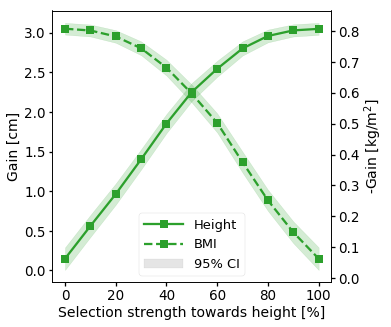

In [391]:
NEGATE_BMI = True
fig, ax = plot_figure_single_box_two_axes(so_wgain, negate_bmi=NEGATE_BMI);

In [181]:
file_name = ("multitrait-gain-by-select-strength" +
             "_twinx" +  
            ("_neg-bmi" if NEGATE_BMI else "") +
            ("_thick" if PLOT_THICKENS else ""))
print(file_name)
plot.save_fig(fig, file_name, SAVE_FIG_DIR)

multitrait-gain-by-select-strength_twinx_neg-bmi_thick
